In [1]:
# Data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# Statistical/mathmatical imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from math import sqrt
import math
# ML imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
# Premade functions
import acquire as a
import wrangle as w
import explore as e
#Removes big scary warnings
import warnings
warnings.filterwarnings('ignore')
seed = 42

In [2]:
df = a.get_zillow_data()

In [3]:
df = w.prep_zillow(df)

In [4]:
train, validate, test = w.split_zillow(df)

In [5]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, 
             columns_to_scale=['bedrooms', 'bathrooms', 'house_sqft'],
             return_scaler=False)

In [6]:
#isolate X and y train 
X_train = train[['bedrooms', 'bathrooms', 'house_sqft']]
y_train = train[['tax_value']]

X_validate = validate[['bedrooms', 'bathrooms', 'house_sqft']]
y_validate = validate[['tax_value']]

X_test = test[['bedrooms', 'bathrooms', 'house_sqft']]
y_test = test[['tax_value']]

In [7]:
#drop columns we don't need 
preds = train.drop(columns=['year_built','lot_size_sqft'])

In [8]:
baseline = round(train['tax_value'].mean(), 2)
baseline

368639.78

In [9]:
#fit the model
model = LinearRegression().fit(X_train, y_train)

#make sure the model is made
model

LinearRegression()

In [10]:
#use the model
predictions = model.predict(X_train)

#take a look at the predictions
predictions

array([[326227.13802515],
       [335273.53682238],
       [232560.98946786],
       ...,
       [268572.61544914],
       [341907.79982173],
       [252370.04602964]])

In [11]:
#create a column that contains just the predictions
train['yhat'] = predictions

In [12]:
#create a column for residual
train['residuals'] =  train.yhat - train.tax_value

In [13]:
train.head()

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built,yhat,residuals
31949,3,2.0,1404,176411,7704,1957,326227.138025,149816.138025
51617,3,2.0,1456,72444,5369,1954,335273.536822,262829.536822
42382,3,1.0,1055,64630,6550,1953,232560.989468,167930.989468
7098,4,1.0,1351,69894,5350,1953,246210.408915,176316.408915
43253,3,1.0,1010,57978,6365,1961,224732.375124,166754.375124


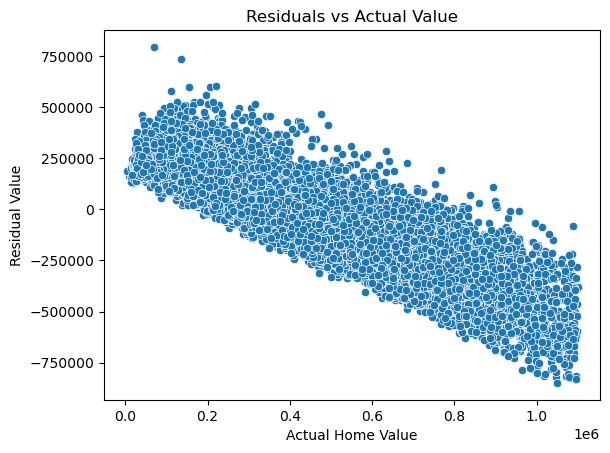

In [14]:
#let's visualize our actual vs our residuals
sns.scatterplot(data=train, x='tax_value', y='residuals')

plt.xlabel('Actual Home Value')
plt.ylabel('Residual Value')
plt.title('Residuals vs Actual Value')
plt.show()

In [15]:
#calculate sum of squared errors (SSE)
SSE = (train.residuals **2).sum()
SSE

1062883091369704.0

In [16]:
ESS = ((train.yhat - train.tax_value.mean())**2).sum()
ESS

309444831880643.2

In [17]:
TSS = ESS + SSE
TSS

1372327923250347.2

In [18]:
#one way to accomplish this
SSE/len(train.yhat)

45039327571.91847

In [19]:
#another way to accomplish this using a library
MSE = mean_squared_error(train.tax_value, train.yhat)
MSE

45039327571.91847

In [20]:
#take the square root of Mean Squared Error
RMSE = MSE**.5
RMSE

212224.71008795954

In [21]:
#another way to accomplish this using sqft function from math library
math.sqrt(MSE)

212224.71008795954

In [22]:
#create our baseline column
train['baseline'] = train.tax_value.mean()

In [23]:
MSE_baseline = mean_squared_error(train.tax_value, train.baseline)
MSE_baseline

58151952339.09115

In [24]:
#create a column for SSE baseline column
train['MSE_baseline'] = MSE_baseline

In [25]:
SSE_baseline = MSE_baseline * len(train)
SSE_baseline

1372327923250212.0

In [26]:
#create a column for SSE baseline column
train['SSE_baseline'] = SSE_baseline

In [27]:
RMSE_baseline = MSE_baseline**.5
RMSE_baseline

241147.15909396723

In [28]:
#create a column for RMSE baseline column
train['RMSE_baseline'] = RMSE_baseline

In [29]:
#take a look
train.head(3)

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built,yhat,residuals,baseline,MSE_baseline,SSE_baseline,RMSE_baseline
31949,3,2.0,1404,176411,7704,1957,326227.138025,149816.138025,368639.775838,5.815195e+10,1.372328e+15,241147.159094
51617,3,2.0,1456,72444,5369,1954,335273.536822,262829.536822,368639.775838,5.815195e+10,1.372328e+15,241147.159094
42382,3,1.0,1055,64630,6550,1953,232560.989468,167930.989468,368639.775838,5.815195e+10,1.372328e+15,241147.159094


In [30]:
if SSE < SSE_baseline:
    print('My OSL model performs better than baseline')
else:
    print('My OSL model performs worse than baseline. :( )')

My OSL model performs better than baseline


In [31]:
#First, let's perform this manually
R2 = ESS / TSS
R2

0.22548898600541895

In [32]:
#make it pretty
print('R-squared = ',round(R2,3))
print("Percent of variance = ", round(R2*100,1), "%")

R-squared =  0.225
Percent of variance =  22.5 %


In [33]:
#now, we can use sklearn function for R2 score
r2_score(train.tax_value, train.yhat)

0.22548898600534262

In [34]:
#explained variance score- using import
evs = explained_variance_score(train.tax_value, train.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.225


In [35]:
RMSE_baseline - RMSE

28922.449006007693

In [36]:
if RMSE < RMSE_baseline:
    print(f'The model rmse performs better the rmse_baseline')
else:
    print(f'The model rmse performs worse than the rmse_baseline')

The model rmse performs better the rmse_baseline


In [37]:
def model(ml_model,mod_name,X_train,X_validate):
    '''
    ml_model: ml model
    mod_name: name of the model
    X_train: X dataset
    X_val: X dataset
    '''
    model = ml_model
    model.fit(X_train,y_train.value)
    pred = model.predict(X_train).round(1)
    rmse_train =calc_rmse(y_train.value,pred)
    pred = model.predict(X_val).round(1)
    rmse_validate = calc_rmse(y_val.value,pred)
    return rmse_train,rmse_validate,mod_name

In [38]:
train_scaled.head()

,bedrooms,bathrooms,house_sqft,tax_value,lot_size_sqft,year_built
31949,0.500000,0.333333,0.245777,176411,7704,1957
51617,0.500000,0.333333,0.256757,72444,5369,1954
42382,0.500000,0.166667,0.172086,64630,6550,1953
7098,0.666667,0.166667,0.234586,69894,5350,1953
43253,0.500000,0.166667,0.162584,57978,6365,1961


In [39]:
X_train_scaled = train[['bedrooms', 'bathrooms', 'house_sqft']] 
y_train = train['tax_value']

In [42]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(validate[['bedrooms', 'bathrooms', 'house_sqft',]])
validate[['bedrooms', 'bathrooms', 'house_sqft']] = mm_scaler.transform(validate[['bedrooms', 'bathrooms', 'house_sqft']])
X_validate = validate.drop(columns=['tax_value', 'year_built', 'lot_size_sqft'])
X_train = train.drop(columns=['tax_value', 'year_built', 'lot_size_sqft'])
y_validate = validate['tax_value']

In [44]:
lm = LinearRegression()

LinearRegression()

In [45]:
lm.fit(X_train, y_train)

LinearRegression()

In [46]:
lm_preds = lm.predict(X_train)

In [47]:
preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})
preds_df.head()

,actual,lm_preds
31949,176411,176411.0
51617,72444,72444.0
42382,64630,64630.0
7098,69894,69894.0
43253,57978,57978.0


In [48]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
lm_rmse

2.8366003467645175e-10

In [49]:
lasso = LassoLars(alpha=0.1)

In [50]:
lasso.fit(X_train, y_train)

lasso_preds = lasso.predict(X_train)

In [51]:
preds_df['lasso_preds'] = lasso_preds
preds_df.head()

,actual,lm_preds,lasso_preds
31949,176411,176411.0,176427.534301
51617,72444,72444.0,72467.501213
42382,64630,64630.0,64660.411193
7098,69894,69894.0,69923.187057
43253,57978,57978.0,58009.376259


In [52]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

21.725100690034424

In [53]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [54]:
X_polynomial = pf.transform(X_train)

In [55]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

LinearRegression()

In [56]:
preds_df['poly_preds'] = lm2.predict(X_polynomial)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds
31949,176411,176411.0,176427.534301,176411.0
51617,72444,72444.0,72467.501213,72444.0
42382,64630,64630.0,64660.411193,64630.0
7098,69894,69894.0,69923.187057,69894.0
43253,57978,57978.0,58009.376259,57978.0


In [57]:
poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

poly_rmse

2.6652852411259335e-10

In [58]:
lasso2 = LassoLars(alpha=0.1)
lasso2.fit(X_polynomial, y_train)

LassoLars(alpha=0.1)

In [59]:
preds_df['lasso_poly'] = lasso2.predict(X_polynomial)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly
31949,176411,176411.0,176427.534301,176411.0,192631.640362
51617,72444,72444.0,72467.501213,72444.0,96886.870786
42382,64630,64630.0,64660.411193,64630.0,112460.041466
7098,69894,69894.0,69923.187057,69894.0,118911.121820
43253,57978,57978.0,58009.376259,57978.0,107642.856389


In [60]:
lassopoly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))
lassopoly_rmse

25342.12843786727

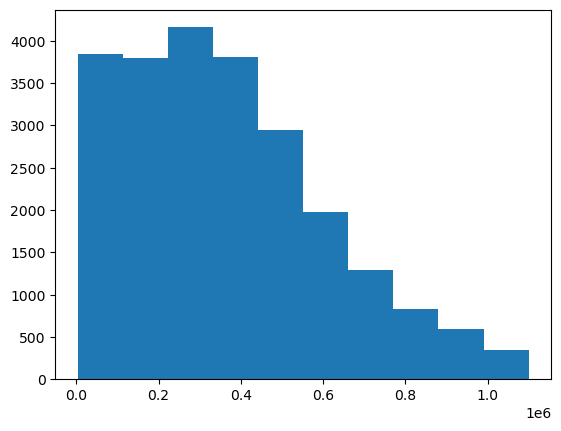

In [61]:
plt.hist(y_train)
plt.show()

In [62]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train, y_train)

TweedieRegressor(power=0)

In [63]:
preds_df['tweedie'] = tweedie.predict(X_train)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly,tweedie
31949,176411,176411.0,176427.534301,176411.0,192631.640362,198726.370533
51617,72444,72444.0,72467.501213,72444.0,96886.870786,81839.935855
42382,64630,64630.0,64660.411193,64630.0,112460.041466,150524.057352
7098,69894,69894.0,69923.187057,69894.0,118911.121820,145872.273439
43253,57978,57978.0,58009.376259,57978.0,107642.856389,149344.870277


In [64]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie']))
tweedie_norm

80045.49476047528

In [65]:
tweedie2 = TweedieRegressor(power=1)

tweedie2.fit(X_train, y_train)
preds_df['tweedie2'] = tweedie2.predict(X_train)

In [66]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie2']))
tweedie_poisson

241147.15909396723

In [67]:
pd.DataFrame({'model': ['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
  'rmse': [lm_rmse, lasso_rmse, poly_rmse, lassopoly_rmse, tweedie_norm, tweedie_poisson]})

,model,rmse
0,linear,2.836600e-10
1,lasso,2.172510e+01
2,linear_poly,2.665285e-10
3,lasso_poly,2.534213e+04
4,tweedie_norm,8.004549e+04
5,tweedie_poisson,2.411472e+05


In [68]:
preds_df['baseline'] = y_train.mean()
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly,tweedie,tweedie2,baseline
31949,176411,176411.0,176427.534301,176411.0,192631.640362,198726.370533,368639.775838,368639.775838
51617,72444,72444.0,72467.501213,72444.0,96886.870786,81839.935855,368639.775838,368639.775838
42382,64630,64630.0,64660.411193,64630.0,112460.041466,150524.057352,368639.775838,368639.775838
7098,69894,69894.0,69923.187057,69894.0,118911.121820,145872.273439,368639.775838,368639.775838
43253,57978,57978.0,58009.376259,57978.0,107642.856389,149344.870277,368639.775838,368639.775838


In [69]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline']))

241147.15909396723

# Zillow 2017 Predictions

# Project Description

Like all businesses, Zillow wants to make a profit and keep the profit machine going. We will be looking into the Zillow 2017 transactions and will be able to help predict (with confidence) home values based on certain drivers, statisitical tests, and regression machine learning algorithms..

# Project Goal

- Discover drivers of Single Family home value for Zillow in 2017.
- Use drivers to develop a machine learning model that accurately predicts home value
- This information could be used for furture years in helping Zillow achieve max profit

# Initial Thoughts

- Does more square footage of a home equate more tax value?
- Does the number of bathrooms affect number of bathrooms?
- Does lot size affect tax value?
- Does number of bedrooms have an affect on tax value?


# The Plan

- Acquire data from Sequel Ace database
- Renamed columns to promote readability
- Checked for nulls and outliers
- Checked that data types were appropriate and changed what was necessary  
- Split data into train/validate/test samples

#### Explore data in search of drivers of home value

##### Answer the following initial questions
- Does more square footage of a home equate more tax value?
- Does the number of bathrooms affect tax value?
- Does lot size affect tax value?
- Does the number of bedrooms affect tax value?

# Data Dictionary

| Feature | Definition |
|:--------|:-----------|
|bedroomcnt|Specifies the number of bedrooms in the home|
|bathroomcnt|Specifies the number of bathrooms in the home|
|calculatedfinishedsquarefeet|Specifies the total finished square footage of the home|
|taxvaluedollarcnt|The total tax assessed value of the parcel|
|lotsizesquarefeet|Specifies total square footage of lot the home sits on|
|yearbuilt|Year that the home was built|

# Steps to Reproduce

- Clone this repo.
- Acquire the data from Kaggle
- Put the data in the file containing the cloned repo.
- Run notebook.

# Takeaways and Conclusions

- Square feet, bedrooms, and bathrooms are all drivers to tax value
- Higher bedroom count, higher bathroom count, and higher square footage amount all contribute to a higher tax value of a home


# Recommendations

- Push the homes with above average bedroom count and bathroom count
- Push homes with above average home square footage